<a href="https://colab.research.google.com/github/tbottelbergs/cv_copy/blob/master/CV_V0.0.4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer vision Final project

# Version History
## V0.0.1 
One-hot encoding (based on first class)
Predictions based on softmax (no extra hidden layer of MobileNetV2)
Optimizer='rmsprop', Loss='categorical_crossentropy'
## V0.0.2
Added extra hidden layer of 1024 nodes
Accuracy never rises above 74% (depends on which class is selected as first class)
## V0.0.3
Added multi-label targets
Changed output layer to 'sigmoid' activation function
Changed the loss function to tf.keras.losses.CategoricalCrossentropy(from_logits=True)
Changed the metric to categorical_accuracy
## V0.0.4
Changed loss function to tf.nn.sigmoid_cross_entropy_with_logits

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Fetch data

In [0]:
import os
from skimage import io
from skimage.transform import resize
import numpy as np
import random
import tensorflow as tf
from xml.dom import minidom
import matplotlib.pyplot as plt

In [2]:
!wget -nc http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
!tar -xf VOCtrainval_11-May-2009.tar --totals



--2020-05-03 14:24:38--  http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 935534080 (892M) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2009.tar’

VOCtrainval_11-May- 100%[===================>] 892.19M  40.3MB/s    in 20s     

2020-05-03 14:24:59 (44.1 MB/s) - ‘VOCtrainval_11-May-2009.tar’ saved [935534080/935534080]

Total bytes read: 935536640 (893MiB, 345MiB/s)


To keep in mind:
* In one image, multiple objects can appear (also of different classes)
* Every image has at least one object in it?

In [0]:
voc_root_folder = "/content/VOCdevkit/VOC2009"
imageNamesFile = os.path.join(voc_root_folder,'ImageSets','Main','trainval.txt')
imageNames = np.loadtxt(imageNamesFile, dtype='str')

In [0]:
np.random.seed(5)
random.seed(5)
np.random.shuffle(imageNames)
trainImageNames, validationImageNames, testImageNames = np.split(imageNames, [5000, 6000])

In [5]:
print(trainImageNames[4999]) # 2008_002718
print(validationImageNames[0]) # 2008_004659

2008_000085
2009_002571


In [41]:
CLASSES = ['aeroplane','bicycle','bird','boat','bottle', 'bus','car','cat','chair','cow', 'diningtable','dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']
class_to_idx = dict((c, i) for i, c in enumerate(CLASSES))
idx_to_class = dict((i, c) for i, c in enumerate(CLASSES))
def one_hot_encode(clss):
  encoded = [0 for _ in range(len(CLASSES))]
  for cls in clss:
    encoded[class_to_idx[cls]] = 1
  return encoded
def one_hot_decode(encoded):
  clss = [idx_to_class[idx] for idx, val in enumerate(encoded) if val == 1]
  return clss
a = one_hot_encode(['bicycle', 'bus', 'chair'])
print(a)
print(one_hot_decode(a))

[0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['bicycle', 'bus', 'chair']


In [0]:
image_folder = os.path.join(voc_root_folder, "JPEGImages")
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

def createDataSet(imageNames):
  images = []
  targets = []
  for imageName in imageNames:
    xmlFile = os.path.join(voc_root_folder,'Annotations',imageName + '.xml')
    xml = minidom.parse(xmlFile)
    objectsXml = xml.getElementsByTagName('object')
    objects = []
    image = resize(io.imread(os.path.join(image_folder,imageName + ".jpg")), IMG_SHAPE)
    for objectXml in objectsXml:
      object = objectXml.getElementsByTagName('name')[0].firstChild.nodeValue
      if object not in objects:
        objects.append(object)
    targets.append(one_hot_encode(objects))
    images.append(image)
  return (images,targets)

In [0]:
trainImages, trainTargets = createDataSet(trainImageNames)
validationImages, validationTargets = createDataSet(validationImageNames)

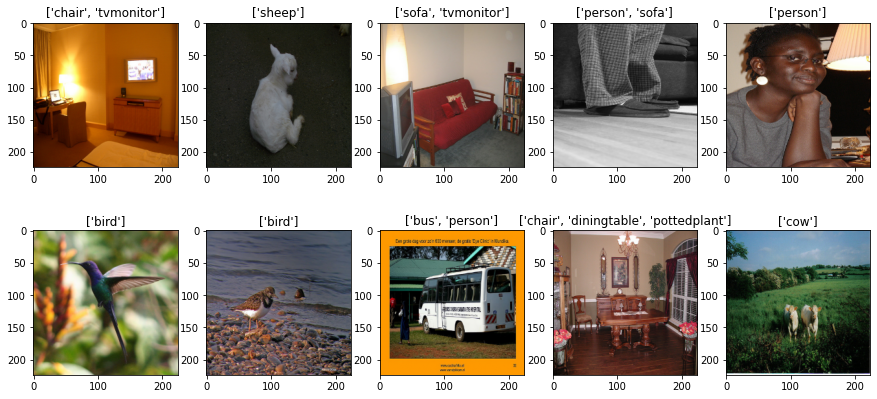

In [44]:
fig=plt.figure(figsize=(15, 7))
for i in range(1,6):
  idx = random.randint(0,len(trainImages))
  fig.add_subplot(2, 5, i)
  plt.imshow(trainImages[idx])
  plt.title(one_hot_decode(trainTargets[idx]))
for i in range(6,11):
  idx = random.randint(0,len(validationImages))
  fig.add_subplot(2, 5, i)
  plt.imshow(validationImages[idx])
  plt.title(one_hot_decode(validationTargets[idx]))

In [0]:
x_train = np.array(trainImages).astype('float32')
y_train = np.array(trainTargetsEncoded)
x_val = np.array(validationImages).astype('float32')
y_val = np.array(validationTargetsEncoded)

In [0]:
BATCH_SIZE = 100
train_batches = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)
validation_batches = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

In [16]:
print(x_val.shape)

(1000, 224, 224, 3)


In [0]:

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [0]:
base_model.trainable = False

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
predictions = tf.keras.layers.Dense(20, activation='sigmoid')
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  tf.keras.layers.Dense(1024, activation='relu', name='hidden_layer'),
  predictions
])
model.compile(optimizer='rmsprop', loss=tf.nn.sigmoid_cross_entropy_with_logits, metrics=['categorical_accuracy'])

* categorical_accuracy: the node with the highest output should also be a detected label
* sigmoid_cross_entropy_with_logits

In [89]:
history = model.fit(train_batches,
                    epochs=10,
                    validation_data=validation_batches)

Epoch 1/10
50/50 [==============================] - 96s 2s/step - loss: 0.6978 - categorical_accuracy: 0.1532 - val_loss: 0.6927 - val_categorical_accuracy: 0.1430
Epoch 2/10
50/50 [==============================] - 96s 2s/step - loss: 0.6927 - categorical_accuracy: 0.1576 - val_loss: 0.6928 - val_categorical_accuracy: 0.1090
Epoch 3/10
50/50 [==============================] - 95s 2s/step - loss: 0.6923 - categorical_accuracy: 0.1448 - val_loss: 0.6927 - val_categorical_accuracy: 0.1320
Epoch 4/10
50/50 [==============================] - 95s 2s/step - loss: 0.6923 - categorical_accuracy: 0.1352 - val_loss: 0.6927 - val_categorical_accuracy: 0.1430
Epoch 5/10
50/50 [==============================] - 95s 2s/step - loss: 0.6923 - categorical_accuracy: 0.1376 - val_loss: 0.6927 - val_categorical_accuracy: 0.1400
Epoch 6/10
50/50 [==============================] - 95s 2s/step - loss: 0.6922 - categorical_accuracy: 0.1216 - val_loss: 0.6926 - val_categorical_accuracy: 0.1240
Epoch 7/10
50/50

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                25620     
Total params: 2,283,604
Trainable params: 25,620
Non-trainable params: 2,257,984
_________________________________________________________________


In [80]:
m = tf.keras.metrics.CategoricalAccuracy() 
_ = m.update_state([[0,0,1,0],[0, 1, 0, 0]], [[0,0.1,0.1,0.2],[0, 1, 0, 0]]) 
m.result().numpy() 

0.5

In [71]:
m = tf.keras.metrics.TopKCategoricalAccuracy(k=2)
_ = m.update_state([[0,0,1,1],[0, 1, 0, 0]], [[0,0.6,0.95,0.2],[0, 1, 0, 0]]) 
m.result().numpy() 

1.0